In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import transforms, models
import torch.nn as nn



**Consistency with Pretrained Models**

1) Input size
- Ensure input images are resized to the model's required dimensions, such as 224x224 pixels for VGG16, to maintain compatibility with the model’s architecture and pretrained weights.

2) Preprocessing
- Scaling to [0-1] and normalizing with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] scales

In [40]:
#from ipywidgets import IProgress
# same option with the imagenet
transform = transforms.Compose([
    transforms.Resize((224, 224)), # VGG16 requires the input to be 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


To highlight the issue of overfitting and to underscore the advantages of transfer learning, we will select a subset consisting of 1,000 training and 200 testing images. With this reduced amount of data, the model may struggle to generalize well.

In [41]:
from torch.utils.data import Subset
import random

# Generate random indices for training and test set
train_indices = random.sample(range(len(trainset)), 1000)  # 1000 random indices for training
test_indices = random.sample(range(len(testset)), 200)    # 200 random indices for testing

# Create training and test subsets
trainset = Subset(trainset, train_indices)
testset = Subset(testset, test_indices)

# Create DataLoader
batch_size = 32  # You can change this value
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


One simple CNN model is designed as below

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=16 * 56 * 56, out_features=120)  # Adjust the in_features
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 56 * 56)  # Reshape to match the new input size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Initialize the network
net = Net()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)  # Use Adam optimizer with learning rate 1e-4

Check the overfitting problem, the model cannot be generalized to the test data

In [14]:
import time

# Initialize
start_time = time.time()

# Number of training epochs
num_epochs = 50

# Initializing lists to store losses and accuracies for each epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Model Training part
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Collect training statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculating and storing average training loss and accuracy
    avg_train_loss = running_loss / len(trainloader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%")

    # Testing (validation)
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Collect test statistics
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculating and storing average test loss and accuracy
    avg_test_loss = running_test_loss / len(testloader)
    avg_test_accuracy = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_accuracy)


Epoch 1, Training Loss: 2.2621, Training Accuracy: 15.70%
Epoch 2, Training Loss: 2.1221, Training Accuracy: 20.90%


KeyboardInterrupt: 

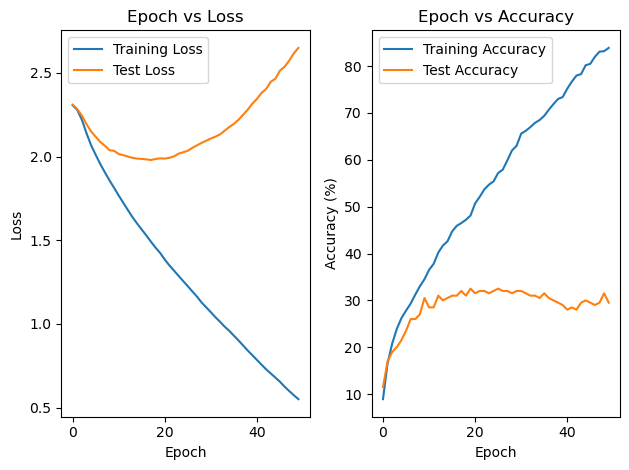

In [8]:
# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## **Transfer Learning**
- Here, we are going to use a pre-trained ResNet model as a starting point for our custom image classification task.
- Notice that pretrained can be set to **False**. This means we are loading the architecture of ResNet18, but not its pre-trained weights. We are going to train the model ourselves!
- Then we replace with the actual number of classes in your custom dataset.
- ResNest doesn't have the FC layers, so we simply replace only the last Conv Layer

In [84]:
resnet_model_without_weights = models.resnet18(weights=None)

# Freeze all layers except the final fully connected layer
for param in resnet_model_without_weights.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes in your custom dataset
num_classes = 10  # Use the number of classes from your custom dataset
resnet_model_without_weights.fc = nn.Linear(resnet_model_without_weights.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model_without_weights.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_without_weights.parameters(), lr=0.001) # check the learning rate

In [16]:
testing_accuracies_resnet_without_weights = []

for epoch in range(50):
    print(epoch)
    resnet_model_without_weights.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model_without_weights(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
    avg_test_accuracy_resnet_without_weights = 100 * correct_test / total_test
    testing_accuracies_resnet_without_weights.append(avg_test_accuracy_resnet_without_weights)
    print(avg_test_accuracy_resnet_without_weights)

0
25.166666666666668
1
25.363636363636363
2
25.6875
3
26.023809523809526
4
26.346153846153847
5
26.612903225806452
6
26.875
7
27.170731707317074
8
27.467391304347824
9
27.764705882352942
10
28.0625
11
28.33606557377049
12
28.583333333333332
13
28.838028169014084
14
29.06578947368421
15
29.290123456790123
16
29.50581395348837
17
29.71978021978022
18
29.942708333333332
19
30.168316831683168
20
30.400943396226417
21
30.626126126126128
22
30.857758620689655
23
31.09090909090909
24
31.321428571428573
25
31.549618320610687
26
31.772058823529413
27
32.0
28
32.215753424657535
29
32.4271523178808
30
32.631410256410255
31
32.82608695652174
32
33.015060240963855
33
33.198830409356724
34
33.38068181818182
35
33.552486187845304
36
33.715053763440864
37
33.8717277486911
38
34.02295918367347
39
34.169154228855724
40
34.31310679611651
41
34.45260663507109
42
34.594907407407405
43
34.737556561085974
44
34.88053097345133
45
35.023809523809526
46
35.16525423728814
47
35.30705394190871
48
35.4451219512195

In [15]:
# Load the pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes in your custom dataset
num_classes = 10  # Use the number of classes from your custom dataset
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)

/home/batya/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/batya/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001) # check the learning rate

In [18]:

for epoch in range(50):
    print(epoch)
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
    avg_train_accuracy_resnet = 100 * correct_test / total_test
    print(avg_train_accuracy_resnet)


0
40.95454545454545
1
48.9375
2
54.19047619047619
3
58.17307692307692
4
61.24193548387097
5
63.763888888888886
6
65.7560975609756
7
67.46739130434783
8
68.98039215686275
9
70.3125
10
71.49180327868852
11
72.5530303030303
12
73.5
13
74.34210526315789
14
75.11728395061728
15
75.83720930232558
16
76.5
17
77.109375
18
77.70297029702971
19
78.28301886792453
20
78.83783783783784
21
79.35775862068965
22
79.85123966942149
23
80.33333333333333
24
80.80534351145039
25
81.25367647058823
26
81.69148936170212
27
82.11301369863014
28
82.51655629139073
29
82.90384615384616
30
83.28260869565217
31
83.64759036144578
32
84.00292397660819
33
84.3465909090909
34
84.68232044198895
35
85.01344086021506
36
85.33507853403141
37
85.64285714285714
38
85.93532338308458
39
86.22087378640776
40
86.49526066350711
41
86.76157407407408
42
87.01809954751131
43
87.26769911504425
44
87.50649350649351
45
87.73516949152543
46
87.95643153526972
47
88.17073170731707
48
88.37848605577689
49
88.583984375


In [19]:
resnet_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_resnet = running_test_loss / len(testloader)
avg_test_accuracy_resnet = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_resnet:.4f}, Test Accuracy: {avg_test_accuracy_resnet:.2f}%")

Test Loss: 0.9796, Test Accuracy: 71.00%


## **Fine tuning**
- small learning rate, small epoch
- Sometimes it is better not to update the CONV layers
- If your domain is a bit different field

In [21]:
# UnFreeze all layers except the final fully connected layer
for param in resnet_model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001) # check the learning rate orig/10

In [22]:
# Training loop
testing_accuracies_resnet_fine_tuning = []
for epoch in range(50):
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
    avg_test_accuracy_resnet_fine_tuning = 100 * correct_test / total_test
    testing_accuracies_resnet_fine_tuning.append(avg_test_accuracy_resnet_fine_tuning)
    print(avg_test_accuracy_resnet_fine_tuning)

62.57905138339921
62.93150684931507
63.28875968992248
63.64107485604607
63.98669201520912
64.32580037664783
64.65858208955224
64.98521256931608
65.3058608058608
65.62068965517241
65.92985611510791
66.23351158645276
66.53180212014134
66.82486865148861
67.11284722222223
67.39586919104991
67.6740614334471
67.94754653130288
68.21644295302013
68.48086522462562
68.74092409240924
68.99672667757774
69.24837662337663
69.49597423510467
69.73961661341853
69.97939778129953
70.21540880503144
70.44773790951638
70.67647058823529
70.90168970814132
71.1234756097561
71.34190620272315
71.55705705705705
71.76900149031296
71.97781065088758
72.18355359765052
72.3862973760933
72.58610709117221
72.7830459770115
72.9771754636234
73.1685552407932
73.35724331926863
73.54329608938548
73.72676837725382
73.90771349862258
74.08618331053351
74.26222826086956
74.43589743589743
74.60723860589812
74.7762982689747


In [24]:
# Set the model to evaluation mode
resnet_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_resnet_fine_tuning = running_test_loss / len(testloader)
avg_test_accuracy_resnet_fine_tuning = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_resnet_fine_tuning:.4f}, Test Accuracy: {avg_test_accuracy_resnet_fine_tuning:.2f}%")


Test Loss: 0.8560, Test Accuracy: 83.00%


Task 1. Report the classification accuracy on the test dataset under different conditions:
- 1) based on our custom model,
- 2) based on a transferred model without importing the weights,
- 3) based on a transferred model with pre-trained weights,
- 4) based on pre-trained weights along with additional training (Fine-tuning).

Task 2. Report what happen if you use the same learning rate (0.001) during the Fine-tuning.

Task 3. Transfer at least two other recent models, and report their accuracy

(Optional) Task 4. Improve the test accuracy using all the possible techniques, and report your highest score in this cell with the simple description on your approach.
Note that you must use the same training (2000), and test (200) images set given in this file. You don't have to get any information from the test dataset (optimal epoch, or parameters)
- Baseline accuracy is 78.50% according to this file

# Task 1

In [29]:
net.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_our_model = running_test_loss / len(testloader)
avg_test_accuracy_our_model = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_our_model:.4f}, Test Accuracy: {avg_test_accuracy_our_model:.2f}%")

Test Loss: 2.6489, Test Accuracy: 29.50%


In [30]:
resnet_model_without_weights.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model_without_weights(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_resnet_without_weights = running_test_loss / len(testloader)
avg_test_accuracy_resnet_without_weights = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_resnet_without_weights:.4f}, Test Accuracy: {avg_test_accuracy_resnet_without_weights:.2f}%")

Test Loss: 1.8784, Test Accuracy: 30.50%


In [32]:
print(f"Test accuracy of our model: {avg_test_accuracy_our_model:.2f}%")
print(f"Test accuracy of resnet model without pre-trained weights: {avg_test_accuracy_resnet_without_weights:.2f}%")
print(f"Test accuracy of resnet model with pre-trained weights: {avg_test_accuracy_resnet:.2f}%")
print(f"Test accuracy of resnet model with pre-trained weights and fine tuning: {avg_test_accuracy_resnet_fine_tuning:.2f}%")


Test accuracy of our model: 29.50%
Test accuracy of resnet model without pre-trained weights: 30.50%
Test accuracy of resnet model with pre-trained weights: 62.31%
Test accuracy of resnet model with pre-trained weights and fine tuning: 83.00%


# Task 2

To test fine tuning with higher learning rate, we should train the resnet model with pre-trained values for one more time.

In [37]:
# Load the pre-trained ResNet model
resnet_model2 = models.resnet18(weights=True)

# Freeze all layers except the final fully connected layer
for param in resnet_model2.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes in your custom dataset
num_classes = 10  # Use the number of classes from your custom dataset
resnet_model2.fc = nn.Linear(resnet_model2.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model2.parameters(), lr=0.001) # check the learning rate

In [39]:
for epoch in range(50):
    print(epoch)
    resnet_model2.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [40]:
# UnFreeze all layers except the final fully connected layer
for param in resnet_model2.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model2.parameters(), lr=0.001) # same learning rate as training the fc layers

In [41]:
for epoch in range(50):
    print(epoch)
    resnet_model2.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [42]:
resnet_model2.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model2(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_resnet_fine_tuning2 = running_test_loss / len(testloader)
avg_test_accuracy_resnet_fine_tuning2 = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_resnet_fine_tuning2:.4f}, Test Accuracy of fine tuning with learning rate od 0.001: {avg_test_accuracy_resnet_fine_tuning2:.2f}%")

Test Loss: 1.3964, Test Accuracy: 71.50%


The accuracy of the resnet model fine tuned with the same learning rate as when training shows significanlty lower results comparing to a fine tuning with smaller learning rate

# Task 3

In [52]:
efficientnet_model = models.efficientnet_v2_s(weights=True)

for param in efficientnet_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes in your custom dataset
num_classes = 10  # Use the number of classes from your custom dataset
efficientnet_model.classifier[1] = nn.Linear(in_features=efficientnet_model.classifier[1].in_features, out_features= num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_model.to(device)

/home/batya/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001) # check the learning rate

In [54]:
for epoch in range(50):
    print(epoch)
    efficientnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #running_loss += loss.item()

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [55]:
efficientnet_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_vgg16_model = running_test_loss / len(testloader)
avg_test_accuracy_vgg16_model = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_vgg16_model:.4f}, Test Accuracy of efficientnet v2: {avg_test_accuracy_vgg16_model:.2f}%")

Test Loss: 0.9352, Test Accuracy of efficientnet v2: 67.50%


The test accuracy of efficient net v2 was lower than resnet model without fine tuning, also it took more time to train it.

In [44]:
vgg16_model =  models.vgg16(weights = True)

for param in vgg16_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes in your custom dataset
num_classes = 10  # Use the number of classes from your custom dataset
vgg16_model.classifier[-1] = nn.Linear(vgg16_model.classifier[-1].in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001) # check the learning rate

In [46]:
for epoch in range(50):
    print(epoch)
    vgg16_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [48]:
vgg16_model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss_vgg16_model = running_test_loss / len(testloader)
avg_test_accuracy_vgg16_model = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss_vgg16_model:.4f}, Test Accuracy of vgg16: {avg_test_accuracy_vgg16_model:.2f}%")

Test Loss: 0.7413, Test Accuracy of vgg16: 78.00%


Vgg16 without fine tuning has higher test accuraccy (6%) than resnet, however it trained for 6 time longer